# Achievable Maximum Operational Intensity

In [1]:
from fastfusion.frontend.workload import Workload, get_tensor_size, get_operation_space_size

workload = Workload.from_yaml('workloads/mha_full_with_gelu.workload.yaml')
all_tensors = workload.tensors
intermediate_tensors = workload.intermediate_tensor_names
non_intermediate_tensors = all_tensors - intermediate_tensors
total_accesses = (
    sum(get_tensor_size(workload, tensor) for tensor in non_intermediate_tensors)
    +
    2*sum(get_tensor_size(workload, tensor) for tensor in intermediate_tensors)
)

total_ops = sum(
    get_operation_space_size(workload, einsum.name)
    for einsum in workload.einsums
)

INFO        Loading yaml file workloads/mha_full_with_gelu.workload.yaml
INFO        Found top key workload in workloads/mha_full_with_gelu.workload.yaml
WARNING     Trying to parse a single element dictionary as a Workload. 


In [2]:
unfused_op_intensity = total_ops / total_accesses
unfused_op_intensity

619.2209302325581

In [3]:
elementwise_fusion_op_intensity = total_ops / (total_accesses - 2*get_tensor_size(workload, 'FFApre'))
elementwise_fusion_op_intensity

682.7307692307693

In [4]:
flat_op_intensity = total_ops / (total_accesses - 2*(get_tensor_size(workload, 'FFApre') + get_tensor_size(workload, 'QK')))
flat_op_intensity

1157.6739130434783

In [8]:
max_op_intensity = total_ops / sum(get_tensor_size(workload, tensor) for tensor in non_intermediate_tensors)
max_op_intensity / flat_op_intensity

1.7692307692307692

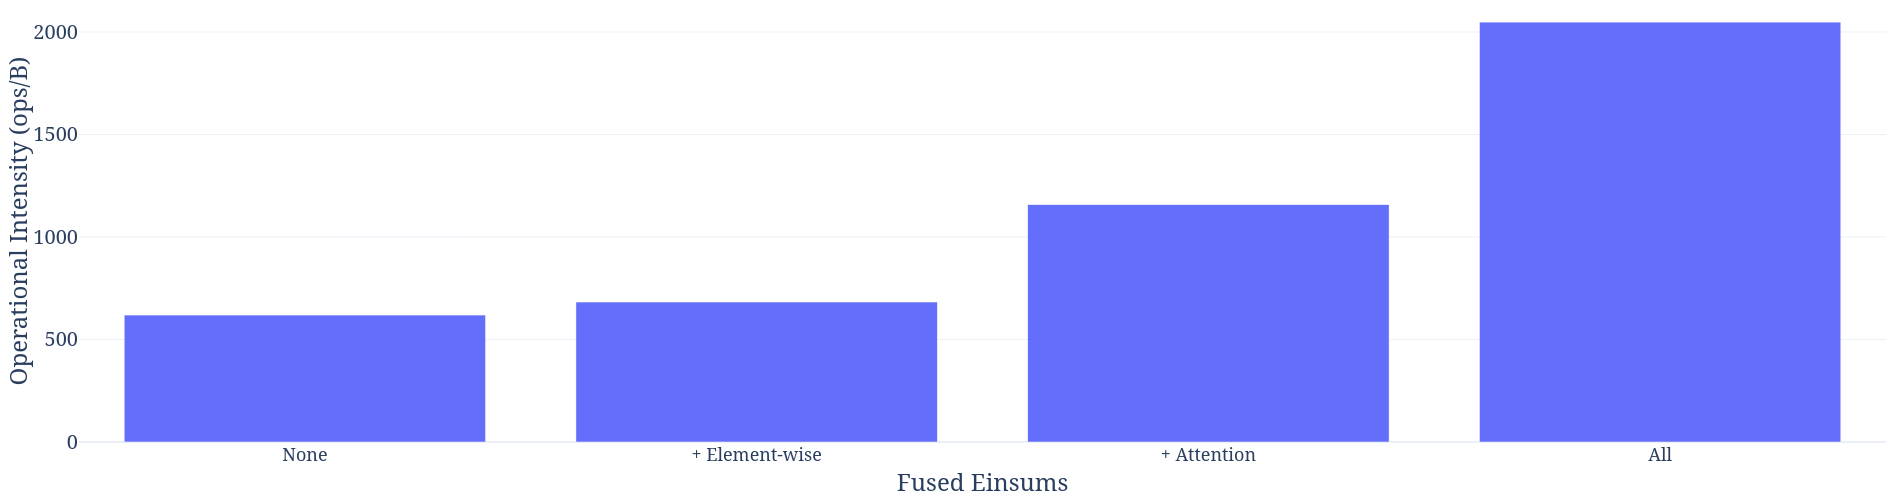

In [7]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.bar({'Fused Einsums': ['None', '+ Element-wise', '+ Attention', 'All'],
              'Operational Intensity (ops/B)': [unfused_op_intensity, elementwise_fusion_op_intensity, flat_op_intensity, max_op_intensity]},
             x='Fused Einsums',
             y='Operational Intensity (ops/B)')
fig.update_layout(
    plot_bgcolor='white',
    font=dict(
        family='Serif',
        size=20
    ),
    xaxis=dict(
        tickangle=0,
        tickfont=dict(size=18),
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    width=700,
    height=500,
    template='plotly_white'
)
fig.show()
fig.write_image('images/op_intensity_potential.pdf')